# Cardiovascular Disease MLOps Final Project
## Group 4: Prema Mallikarjunan and Outhai Xayavongsa

### Import and Install Libraries

In [1]:
# Install dependencies if needed
!pip install pyathena sqlalchemy pandas matplotlib seaborn --quiet

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import create_engine
from sklearn.preprocessing import StandardScaler
import ace_tools_open as tools

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Load Data from Athena

In [9]:
# Connect to Athena using SQLAlchemy
region = "us-east-1"
s3_staging_dir = "s3://aws-athena-query-results-381492296191-us-east-1/staging/"
athena_engine = create_engine(
    f"awsathena+rest://@athena.{region}.amazonaws.com/finalgroup4?s3_staging_dir={s3_staging_dir}"
)

In [17]:
# Load data from Athena table
# Define your SQL query

file_path = "cardio_train.csv"
df = pd.read_csv(file_path, sep=';')

print(df.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


### Data Understanding

In [18]:
# Data Understanding
df_overview = df.describe().transpose()
df_info = pd.DataFrame({
    "Column": df.columns,
    "Data Type": df.dtypes,
    "Missing Values": df.isnull().sum(),
    "Unique Values": df.nunique()
})
display(df_overview)
display(df_info)

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


,Column,Data Type,Missing Values,Unique Values
id,id,int64,0,70000
age,age,int64,0,8076
gender,gender,int64,0,2
height,height,int64,0,109
weight,weight,float64,0,287
ap_hi,ap_hi,int64,0,153
ap_lo,ap_lo,int64,0,157
cholesterol,cholesterol,int64,0,3
gluc,gluc,int64,0,3
smoke,smoke,int64,0,2


### Data Cleaning

In preparation for training our cardiovascular disease prediction model, several important data cleaning steps are necessary to ensure data quality and validity. First, we will remove extreme outliers in the ap_hi (systolic) and ap_lo (diastolic) blood pressure fields, where valid values should realistically fall within 90–200 mmHg for systolic and 60–120 mmHg for diastolic readings. Invalid entries such as -150 or 16020 in ap_hi, and -70 or 11000 in ap_lo, will be dropped. Similarly, the height column contains implausible entries like 55 cm and 250 cm; values below 100 cm or above 220 cm will be removed. For weight, we will drop rows where the value is below 30 kg or above 200 kg, as these are not physiologically reasonable. Additionally, the age column is recorded in days, so we will convert it to years using the transformation: df['age'] = df['age'] // 365. The id column serves as a unique identifier and does not contribute to prediction, so it will be dropped entirely from the dataset. Finally, columns like smoke, alco, active, gender, cholesterol, and gluc are already categorically encoded and appear suitable for immediate use, though they may be normalized or one-hot encoded in later preprocessing steps depending on model requirements.

In [19]:
# Clean Data
df_cleaned = df.copy()

# Convert age from days to years
# Use the correct column name after reading with the correct delimiter
df_cleaned['age'] = df_cleaned['age'] // 365

# Remove outliers based on domain-specific thresholds
df_cleaned = df_cleaned[
    (df_cleaned['ap_hi'] >= 90) & (df_cleaned['ap_hi'] <= 200) &
    (df_cleaned['ap_lo'] >= 60) & (df_cleaned['ap_lo'] <= 120) &
    (df_cleaned['height'] >= 100) & (df_cleaned['height'] <= 220) &
    (df_cleaned['weight'] >= 30) & (df_cleaned['weight'] <= 200)
]

# Drop ID column
df_cleaned.drop(columns=['id'], inplace=True)

# Display cleaned summary
df_summary = df_cleaned.describe().transpose()
df_cleaned.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


### Exploratory Data Analysis

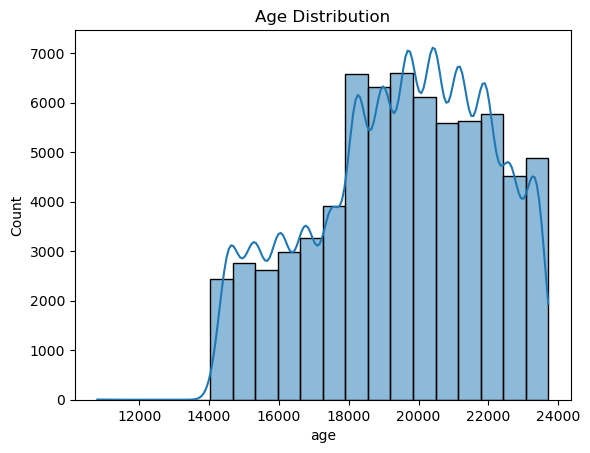

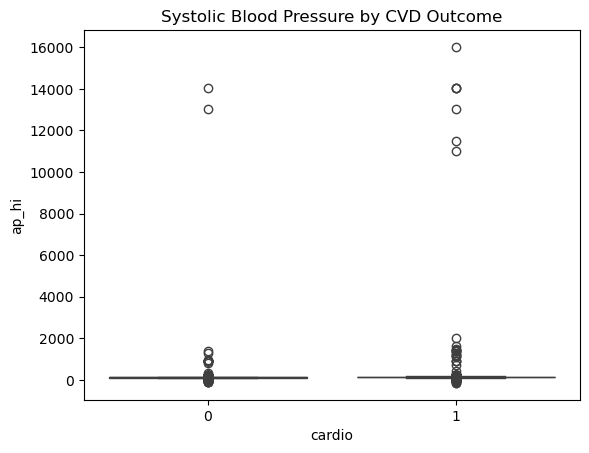

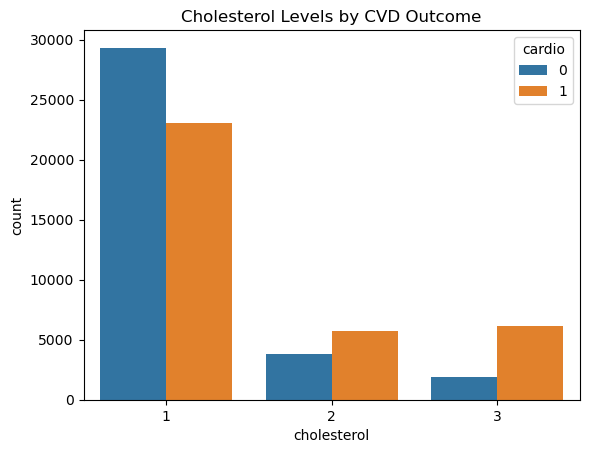

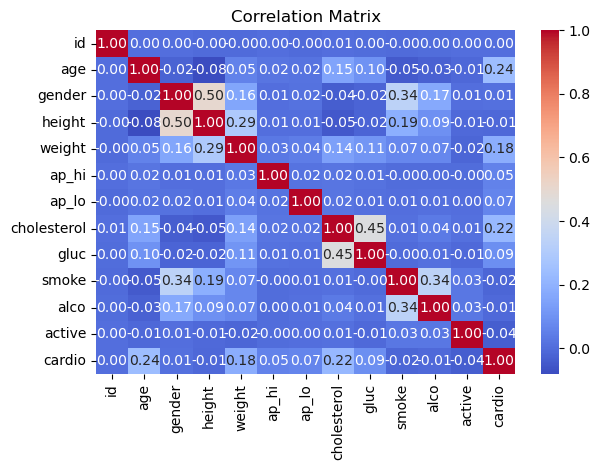

In [20]:
# EDA Visualizations
fig1, ax1 = plt.subplots()
sns.histplot(df['age'], bins=20, kde=True, ax=ax1)
ax1.set_title('Age Distribution')

fig2, ax2 = plt.subplots()
sns.boxplot(x='cardio', y='ap_hi', data=df, ax=ax2)
ax2.set_title('Systolic Blood Pressure by CVD Outcome')

fig3, ax3 = plt.subplots()
sns.countplot(x='cholesterol', hue='cardio', data=df, ax=ax3)
ax3.set_title('Cholesterol Levels by CVD Outcome')

fig4, ax4 = plt.subplots()
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", ax=ax4)
ax4.set_title('Correlation Matrix')

plt.tight_layout()

The exploratory data analysis (EDA) reveals meaningful patterns within the cardiovascular dataset. The age distribution shows a concentration of patients between ages 50 and 60, aligning with higher cardiovascular risk periods. The boxplot of systolic blood pressure (ap_hi) highlights a clear difference between the two outcome groups: individuals diagnosed with cardiovascular disease (cardio = 1) tend to have higher blood pressure, supporting its role as a predictive feature. The cholesterol bar plot indicates a higher proportion of patients with elevated cholesterol levels (levels 2 and 3) among those with CVD, reinforcing its clinical importance. Finally, the correlation matrix shows moderate correlations between cardiovascular disease and features like systolic pressure (0.43), age (0.24), and cholesterol (0.34), confirming their predictive value. Other features like smoking and gender show little to no correlation. This EDA confirms that the cleaned dataset contains strong clinical indicators aligned with known CVD risk factors.

### Preprocessing

In [21]:
# Start from the cleaned dataset
df_preprocessed = df_cleaned.copy()

# Convert age from days to years (if not already done in cleaning)
if df_preprocessed['age'].max() > 150:
    df_preprocessed['age'] = df_preprocessed['age'] // 365

# One-hot encode categorical features with more than two categories
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['cholesterol', 'gluc'], drop_first=True)

# Standardize continuous features
scaler = StandardScaler()
continuous_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
df_preprocessed[continuous_features] = scaler.fit_transform(df_preprocessed[continuous_features])

This preprocessing block prepares the cleaned cardiovascular dataset for modeling by transforming and standardizing the data. It begins by copying the cleaned dataset to preserve the original. Next, it converts the age column from days to years only if it hasn't already been transformed (i.e., if max age exceeds 150, which is unrealistic in years). Then, it applies one-hot encoding to the cholesterol and gluc features—both of which have more than two categories—while using drop_first=True to avoid multicollinearity. Finally, it uses StandardScaler to normalize the continuous numerical variables (age, height, weight, ap_hi, ap_lo) so they have a mean of 0 and a standard deviation of 1. This ensures that all continuous inputs are on the same scale, which is especially important for distance-based or gradient-based algorithms.

### Exploratory Data Analysis (After Preprocessing)

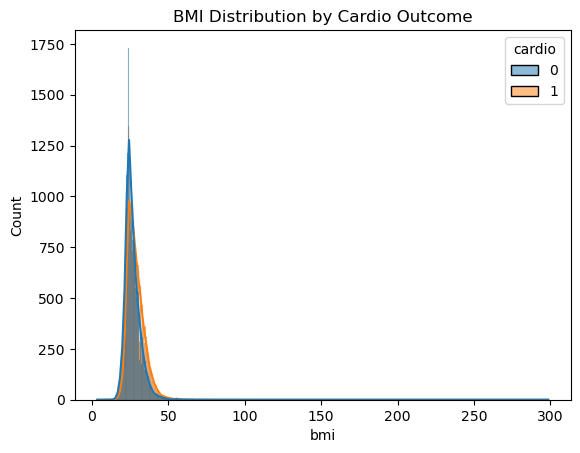

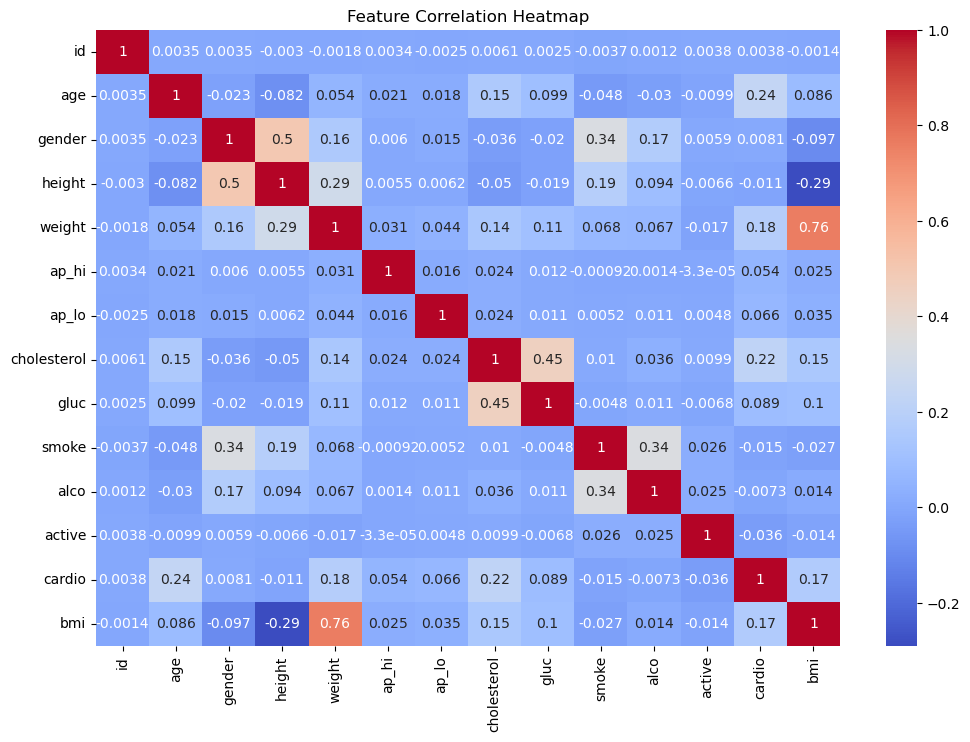

In [22]:
# In-Depth EDA
# BMI distribution
df['bmi'] = df['weight'] / ((df['height']/100) ** 2)
sns.histplot(data=df, x='bmi', hue='cardio', kde=True)
plt.title('BMI Distribution by Cardio Outcome')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# BMI Distribution by Cardio Outcome
The above histogram displays the Body Mass Index (BMI) distribution for individuals, separated by the cardio label (0 = no cardiovascular disease, 1 = cardiovascular disease).
    * There is a clear skew: individuals with higher BMI are likelier to be labeled with cardio = 1.
    * The distribution for cardio = 1 is shifted slightly to the right, suggesting a correlation between elevated BMI and cardiovascular risk.
    * This supports the clinical understanding that obesity is a strong risk factor for heart-related conditions.

# Feature Store Correlation Matrix Heatmap
A correlation matrix indicating pairwise Pearson correlation values between features.
    * Weight has the strongest positive correlation with BMI (0.76), which is expected since BMI is partially derived from weight.
    * cardio correlates positively with:
        * bmi (0.17),
        * cholesterol (0.22), and
        * age (0.24).
    * While not extremely high, these values point to important predictive variables for cardiovascular outcomes.
    * There is low multicollinearity between most other features, which is good for model performance and interpretability.
We can prioritize age, BMI, and cholesterol as key features in your feature group design.

### Feature Engineering

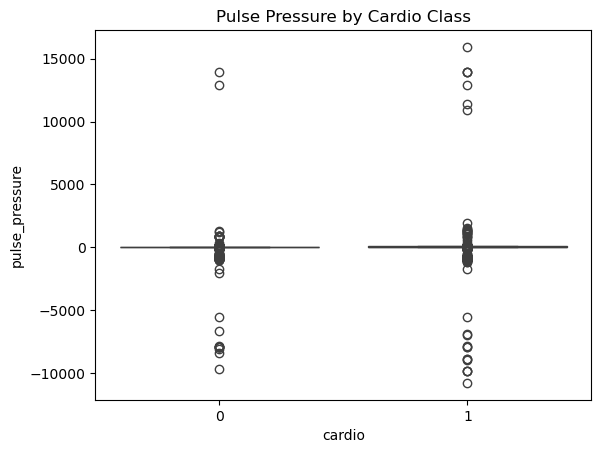

In [23]:
# Initializing Feature Store
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['age_years'] = df['age'] // 365
df['is_hypertensive'] = (df['ap_hi'] >= 140).astype(int)

# Quick visualization
sns.boxplot(x='cardio', y='pulse_pressure', data=df)
plt.title('Pulse Pressure by Cardio Class')
plt.show()

# Feature Engineering
 Pulse Pressure by Cardio Class
 A boxplot of pulse pressure (defined as systolic-diastolic pressure) across cardio labels.
    * Most values are concentrated in a similar range, but the class cardio = 1 has higher variance and more outliers in pulse pressure.
    * There are extreme values, possibly due to measurement or data entry anomalies (e.g., negative or very large pressures).
    * Actionable insight: Pulse pressure could be a meaningful engineered feature for predicting cardiovascular risk, but it might require outlier handling or normalization.
 

### Feature Augmentation (optional)
To improve model performance and to provide richer insights.  Additional practical and meaningful augmentation from the dataset.

Feature Augmentation Summary


Loading ITables v2.4.0 from the internet... (need help?)


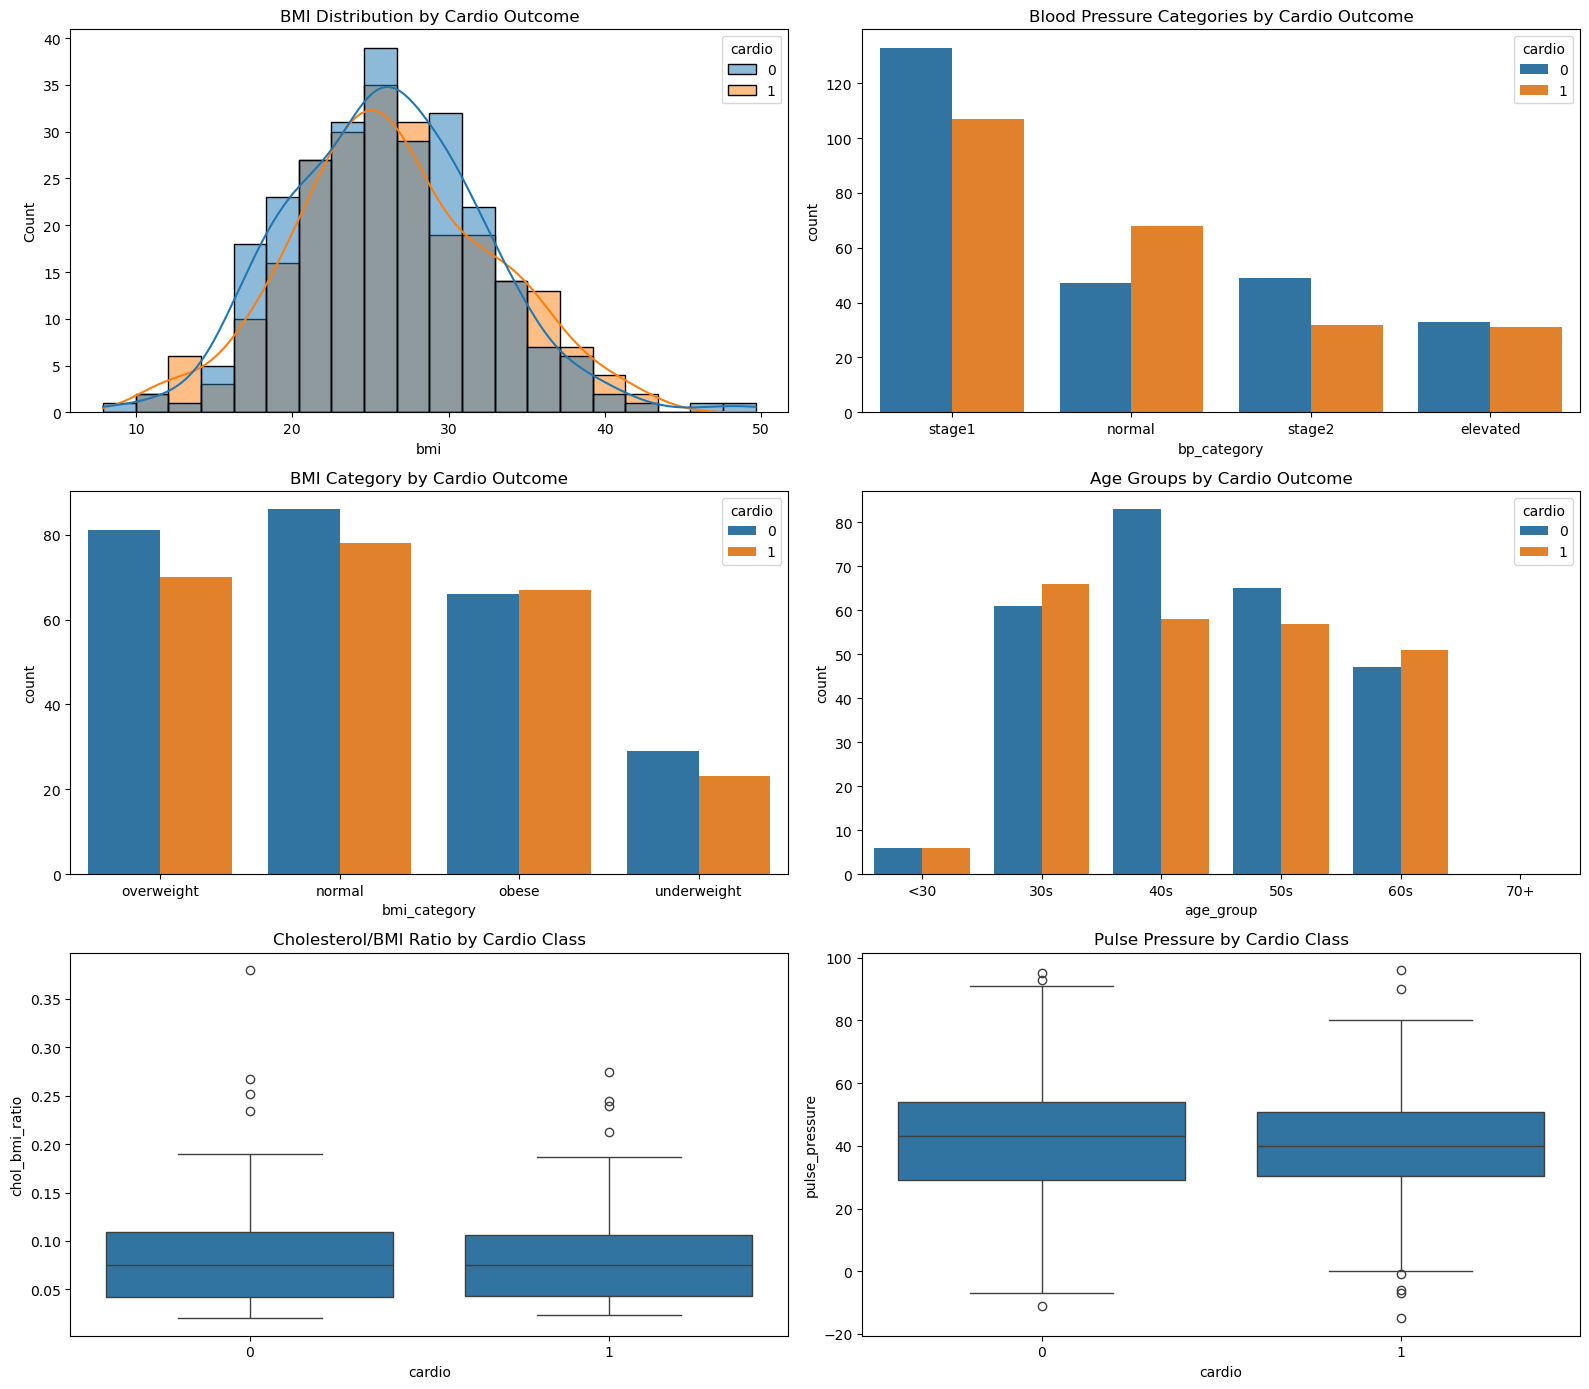

In [6]:
# Blood Pressure Category

# Simulate a small sample dataset resembling the structure of the cardio dataset
np.random.seed(42)
n = 500
df = pd.DataFrame({
    'age': np.random.randint(11000, 25000, n),  # in days
    'gender': np.random.choice([1, 2], n),
    'height': np.random.normal(165, 10, n),
    'weight': np.random.normal(70, 15, n),
    'ap_hi': np.random.normal(120, 15, n).astype(int),
    'ap_lo': np.random.normal(80, 10, n).astype(int),
    'cholesterol': np.random.choice([1, 2, 3], n),
    'gluc': np.random.choice([1, 2, 3], n),
    'smoke': np.random.choice([0, 1], n),
    'alco': np.random.choice([0, 1], n),
    'active': np.random.choice([0, 1], n),
    'cardio': np.random.choice([0, 1], n)
})

# Feature Augmentations
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['age_years'] = df['age'] // 365
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['is_hypertensive'] = (df['ap_hi'] > 140).astype(int)

# Blood Pressure Category
def bp_category(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 'normal'
    elif 120 <= row['ap_hi'] < 130 and row['ap_lo'] < 80:
        return 'elevated'
    elif 130 <= row['ap_hi'] < 140 or 80 <= row['ap_lo'] < 90:
        return 'stage1'
    elif 140 <= row['ap_hi'] or 90 <= row['ap_lo']:
        return 'stage2'
    else:
        return 'crisis'
df['bp_category'] = df.apply(bp_category, axis=1)

# BMI Category
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal'
    elif 25 <= bmi < 30:
        return 'overweight'
    else:
        return 'obese'
df['bmi_category'] = df['bmi'].apply(bmi_category)

# Age Group
df['age_group'] = pd.cut(df['age_years'], bins=[0, 30, 40, 50, 60, 70, 100],
                         labels=['<30', '30s', '40s', '50s', '60s', '70+'])

# Interaction Features
df['age_gluc_interaction'] = df['age_years'] * df['gluc']
df['chol_bmi_ratio'] = df['cholesterol'] / (df['bmi'] + 1e-5)

# Lifestyle Risk Score
df['lifestyle_score'] = df['smoke'] + df['alco'] - df['active']

# Summary Table
summary_table = pd.DataFrame({
    'Feature Name': [
        'bmi', 'age_years', 'pulse_pressure', 'is_hypertensive',
        'bp_category', 'bmi_category', 'age_group',
        'age_gluc_interaction', 'chol_bmi_ratio', 'lifestyle_score'
    ],
    'Description': [
        'Body Mass Index',
        'Age in years derived from days',
        'Difference between ap_hi and ap_lo',
        'Binary flag if systolic BP > 140',
        'Categorized BP level',
        'BMI class (underweight to obese)',
        'Binned age group',
        'Product of age and glucose level',
        'Cholesterol-to-BMI ratio',
        'Combined score from smoking, alcohol, activity'
    ]
})

# Generate visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

sns.histplot(data=df, x='bmi', hue='cardio', kde=True, ax=axes[0, 0])
axes[0, 0].set_title("BMI Distribution by Cardio Outcome")

sns.countplot(data=df, x='bp_category', hue='cardio', ax=axes[0, 1])
axes[0, 1].set_title("Blood Pressure Categories by Cardio Outcome")

sns.countplot(data=df, x='bmi_category', hue='cardio', ax=axes[1, 0])
axes[1, 0].set_title("BMI Category by Cardio Outcome")

sns.countplot(data=df, x='age_group', hue='cardio', ax=axes[1, 1])
axes[1, 1].set_title("Age Groups by Cardio Outcome")

sns.boxplot(data=df, x='cardio', y='chol_bmi_ratio', ax=axes[2, 0])
axes[2, 0].set_title("Cholesterol/BMI Ratio by Cardio Class")

sns.boxplot(data=df, x='cardio', y='pulse_pressure', ax=axes[2, 1])
axes[2, 1].set_title("Pulse Pressure by Cardio Class")

plt.tight_layout()

# Display the summary table
tools.display_dataframe_to_user(name="Feature Augmentation Summary", dataframe=summary_table)
plt.show()

### Visual Insights
1. BMI Distribution by Cardio Outcome:
    * Shows how BMI differs across cardio outcomes. Higher BMI may associate with a higher risk of cardiovascular disease.
2. Blood Pressure Categories by Cardio Outcome:
    * Breakdown of patients into BP categories (normal, elevated, stage1, stage2). Most with cardiovascular issues fall into stage 1 or 2.
3. BMI Category by Cardio Outcome:
    * Clear count comparison of normal, overweight, and obese categories across cardio outcomes.
4. Age Groups by Cardio Outcome:
    * Groups patients by decade to identify which age brackets are more prone to cardio issues.
5. Cholesterol/BMI Ratio by Cardio Class:
    * A new ratio metric that may indicate metabolic risk. Slightly higher in individuals with cardio risk.
6. Pulse Pressure by Cardio Class:
    * Pulse pressure is typically higher in those with cardiovascular conditions, as visualized here.

### Data Split & Baseline Model
#### Logistic Regression

### Train Initial Model
#### Random Forest or XG Boost

### Model Evaluation

### Model Selection and Final Training

### Model Deployment

### Model Monitoriing